In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
from datetime import datetime
%matplotlib inline

In [2]:
dayframes = {
    (0, 5*60+23): 'NIGHT',
    (5*60+24, 5*60+56): 'TWILIGHT',
    (5*60+57, 20*60+33): 'DAYLIGHT',
    (20*60+34, 21*60+6): 'TWILIGHT',
    (21*60+7, 24*60): 'NIGHT'
}

Detected_Activity_List = {
  0.0 : "IN_VEHICLE",
  1.0 : "ON_BICYCLE",
  2.0 : "ON_FOOT",
  3.0 : "STILL",
  4.0 : "UNKNOWN",
  5.0 : "TILTING",
  7.0 : "WALKING",
  8.0 : "RUNNING"
}

sensor_type_dict = {
    'MONITORING':-1,
    'INDOOR':-2,
    'GPS_SATELLITES':-3,
    'GPS_FIX_SATELLITES':-4,
    'GPS_FIX':-5,
    'DETECTED_ACTIVITY':-6,
    'WIFI_ACCESS_POINTS':-7,
    'BLUETOOTH_DEVICES':-8
}


ordered_columns = [
    'LUMINOSITY',

    'LUMINOSITY30S',
    'LAST_LUMINOSITY_WHEN_FAR',
    'LAST_LUMINOSITY30S_WHEN_FAR',
    'TIME_FROM_LAST_FAR',

    'WIFI_ACCESS_POINTS',
    'BLUETOOTH_DEVICES',
    'GPS_SATELLITES',
    'GPS_FIX_SATELLITES',
    'GPS_TIME_FROM_FIX',

    'PROXIMITY',
    'DAYLIGHT',
    'TWILIGHT',
    'NIGHT',
    'IN_VEHICLE',
    'ON_BICYCLE',
    'ON_FOOT',
    'STILL',
    'TILTING',
    'WALKING',
    'RUNNING',

    'INDOOR'
]

In [3]:
def preprocess_data(inputFile):
    df = pd.read_csv(inputFile)
    df.loc[:,'FileName'] = inputFile
    for index,row in df.iterrows():
        if  df.loc[index,'sensor_type'] == -1:
            df.loc[index,'sensor_type'] = sensor_type_dict[ row['sensor_name']]
    
    last_seen_values = {}
    sensor_types = df['sensor_name'].unique()
    for sensor_type in sensor_types:
        last_seen_values[sensor_type] = float('nan')

    proximity_name = ""
    light_name = ""

    for sensor_type in sensor_types:
        if 'proximity' in sensor_type.lower():
            proximity_name = sensor_type
            continue
        if 'light' in sensor_type.lower():
            light_name = sensor_type
    
    switchlist = []
    for _,row in df.iterrows():
        if row['sensor_name'] == 'INDOOR':
            switchlist.append(row['timestamp'])
    droplist = []
    for index,row in df.iterrows():
        if row['sensor_name'] != light_name:
            continue
        for switch in switchlist:
            if row['timestamp'] > switch - 3*1000 and row['timestamp'] < switch + 3*1000:
                droplist.append(index)
    df.drop(droplist, inplace=True)
    
    df_wide = df.pivot_table(index=['FileName','timestamp'], columns='sensor_name', values='value', aggfunc='first')

    last_gps_fix = -1
    last_lum_far = float('nan')
    time_last_far = -1
    is_far = True
    lumfar = {}
    for index,row in df_wide.iterrows():
        if row['MONITORING'] == 0:
            for sensor_type in sensor_types:
                last_seen_values[sensor_type] = float('nan')
            last_gps_fix = -1
            last_lum_far = float('nan')
            time_last_far = -1
            is_far = True
            lumfar = {}
        else:
            if row['GPS_FIX'] > 0:
                last_gps_fix = index[1]
            if last_gps_fix == -1:
                df_wide.loc[index,'GPS_FIX'] = -1
            else:
                df_wide.loc[index, 'GPS_FIX'] = (index[1] - last_gps_fix)/1000
            if not math.isnan(row[proximity_name]):
                is_far = row[proximity_name] > 0.0
            if (not math.isnan(row[light_name])) and is_far:
                last_lum_far = row[light_name]
            if (is_far or time_last_far == -1) and not math.isnan(last_lum_far):
                time_last_far = index[1]
                lumfar[index[1]] = last_lum_far
            if time_last_far == -1:
                time_last_far = index[1]
            df_wide.loc[index, "TIME_FROM_LAST_FAR"] = (index[1] - time_last_far)/1000
            df_wide.loc[index, 'LAST_LUMINOSITY_WHEN_FAR'] = last_lum_far
            lum30s = df[(df['timestamp'] >= (index[1] - 30*1000)) & (df['timestamp'] <= index[1]) & (df['sensor_name'] == light_name)]['value'].mean()
            df_wide.loc[index, 'LUMINOSITY30S'] = lum30s
            lumfar = {k: v for k, v in lumfar.items() if k >= (time_last_far - 30*1000)}
            if len(lumfar.values()) > 0:
                lumsum = 0
                for value in lumfar.values():
                    lumsum += value
                lum30sFar = lumsum/len(lumfar.values())
            else:
                lum30sFar = last_lum_far
            df_wide.loc[index, 'LAST_LUMINOSITY30S_WHEN_FAR'] = lum30sFar
            for sensor_type in sensor_types:
                if math.isnan(row[sensor_type]):
                    df_wide.loc[index,sensor_type] = last_seen_values[sensor_type]
                last_seen_values[sensor_type] = row[sensor_type] 

    for index,row in df_wide.iterrows():
        containsNaN = 0.0
        for feature in df_wide.columns:
            if feature != 'containsNaN' and math.isnan(row[feature]):
                containsNaN = 1.0
                break
        df_wide.loc[index,'containsNaN'] = containsNaN
    
    for index,row in df_wide.iterrows():
        dt = datetime.fromtimestamp(index[1] / 1000)
        minofday = dt.hour * 60 + dt.minute
        for key in dayframes.keys():
            if minofday < key[1] and minofday > key[0]:
                 df_wide.loc[index, 'TIME_OF_DAY'] = dayframes[key]

    for value in dayframes.values(): 
        df_wide[value] = df_wide['TIME_OF_DAY'] == value  

    del df_wide['TIME_OF_DAY']

    df_wide = df_wide[(df_wide['MONITORING'] == 1.0) & (df_wide['containsNaN'] == 0.0) & (df_wide['GPS_FIX'] != -1)] 
    del df_wide['containsNaN']

    df_wide.loc[(df_wide[proximity_name] > 0.0),proximity_name] = 1

    for key in Detected_Activity_List.keys(): 
        df_wide[Detected_Activity_List[key]] = df_wide['DETECTED_ACTIVITY'] == key

    df_wide.sort_values(['timestamp'], inplace=True)
    del df_wide['MONITORING']
    del df_wide['DETECTED_ACTIVITY']
    del df_wide['UNKNOWN']
    
    cols = [sensor_type for sensor_type in df_wide.columns.to_list() if sensor_type != proximity_name]
    cols.append(proximity_name)
    df_wide = df_wide[cols].replace(True,1.0).replace(False,0.0)
    df_wide.rename(columns={light_name: "LUMINOSITY", proximity_name: "PROXIMITY", 'GPS_FIX': "GPS_TIME_FROM_FIX"}, inplace=True)
    df_wide = df_wide[ordered_columns]
    return df_wide

from os import walk,path

dfs = []
root_directory = "datasets"
_, _, filenames = next(walk(root_directory))
for filename in filenames:
    print(filename)
    if not filename.endswith('.csv'):
        continue
    x = path.join(root_directory,filename)
    dfs.append(preprocess_data(x))
    
df_wide = pd.concat(dfs)
    
df_wide

collected-data_N_2.csv
collected-data_Z_4.csv
collected-data_Z_2.csv
collected-data_D.csv
collected-data_Z_5.csv
collected-data_N_1.csv
collected-data_R.csv
test-data_N.csv
collected-data_Z_3.csv


sensor_name                                    LUMINOSITY  LUMINOSITY30S  \
FileName                        timestamp                                  
datasets/collected-data_N_2.csv 1620830494950         5.0       5.166667   
                                1620830502206         5.0       5.000000   
                                1620830556009         4.0       4.000000   
                                1620830560042         5.0       4.500000   
                                1620830561971         7.0       5.333333   
...                                                   ...            ...   
datasets/collected-data_Z_3.csv 1620929553614         6.0       6.535714   
                                1620929554686         7.0       5.964286   
                                1620929555758         7.0       5.714286   
                                1620929556830        12.0       5.892857   
                                1620929585568        12.0       9.500000   

sensor_name                                    LAST_LUMINOSITY_WHEN_FAR  \
FileName                        timestamp                                 
datasets/collected-data_N_2.csv 1620830494950                       5.0   
                                1620830502206                       5.0   
                                1620830556009                       4.0   
                                1620830560042                       5.0   
                                1620830561971                       7.0   
...                                                                 ...   
datasets/collected-data_Z_3.csv 1620929553614                       6.0   
                                1620929554686                       7.0   
                                1620929555758                       7.0   
                                1620929556830                      12.0   
                                1620929585568                      12.0   

sensor_name                                    LAST_LUMINOSITY30S_WHEN_FAR  \
FileName                        timestamp                                    
datasets/collected-data_N_2.csv 1620830494950                     5.333333   
                                1620830502206                     5.000000   
                                1620830556009                     4.900000   
                                1620830560042                     4.909091   
                                1620830561971                     5.083333   
...                                                                    ...   
datasets/collected-data_Z_3.csv 1620929553614                     6.823529   
                                1620929554686                     6.352941   
                                1620929555758                     6.147059   
                                1620929556830                     5.812500   
                                1620929585568                    10.333333   

sensor_name                                    TIME_FROM_LAST_FAR  \
FileName                        timestamp                           
datasets/collected-data_N_2.csv 1620830494950                 0.0   
                                1620830502206                 0.0   
                                1620830556009                 0.0   
                                1620830560042                 0.0   
                                1620830561971                 0.0   
...                                                           ...   
datasets/collected-data_Z_3.csv 1620929553614                 0.0   
                                1620929554686                 0.0   
                                1620929555758                 0.0   
                                1620929556830                 0.0   
                                1620929585568                 0.0   

sensor_name                                    WIFI_ACCESS_POINTS  \
FileName                        timestamp            

In [4]:
df_wide['INDOOR'].value_counts()

0.0    18468
1.0    13020
Name: INDOOR, dtype: int64

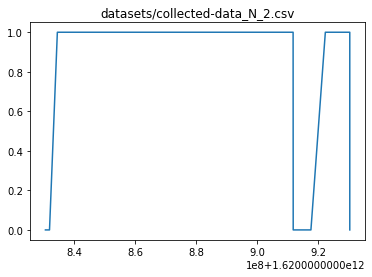

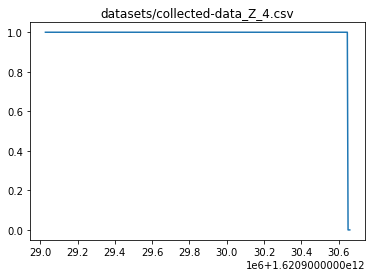

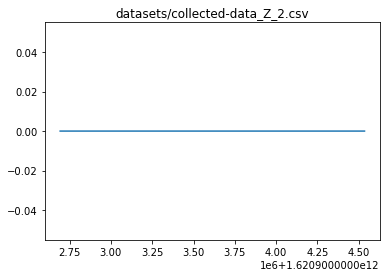

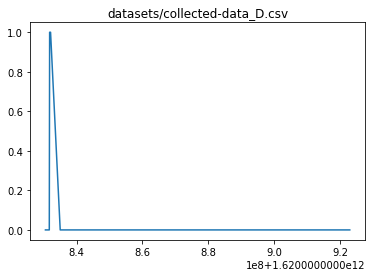

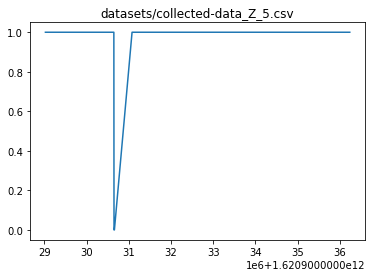

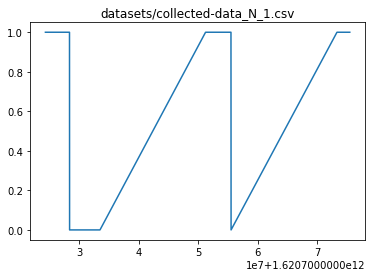

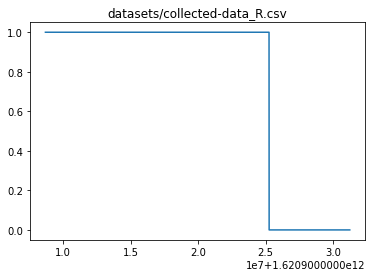

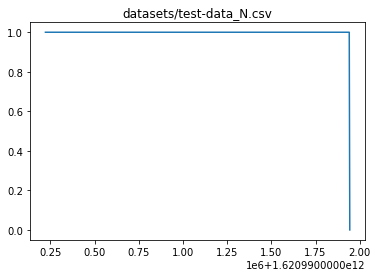

In [5]:
last_filename = None
time = []
indoor = []
for index,row in df_wide.iterrows():
    filename = index[0]
    if last_filename == None:
        last_filename = filename
    if last_filename != filename:
        plt.plot(time,indoor)
        plt.title(last_filename)
        plt.show()
        plt.close()
        time = []
        indoor = []
        last_filename = filename
    time.append(index[1])
    indoor.append(row['INDOOR'])

In [6]:
descb = df_wide.describe()
descb

sensor_name,LUMINOSITY,LUMINOSITY30S,LAST_LUMINOSITY_WHEN_FAR,LAST_LUMINOSITY30S_WHEN_FAR,TIME_FROM_LAST_FAR,WIFI_ACCESS_POINTS,BLUETOOTH_DEVICES,GPS_SATELLITES,GPS_FIX_SATELLITES,GPS_TIME_FROM_FIX,...,TWILIGHT,NIGHT,IN_VEHICLE,ON_BICYCLE,ON_FOOT,STILL,TILTING,WALKING,RUNNING,INDOOR
count,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,...,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.0,31488.0,31488.000000
mean,1387.348673,1379.041643,1827.060309,1994.333845,172.206807,4.801353,2.773183,20.113694,5.122428,65.338524,...,0.038745,0.072123,0.005208,0.003874,0.222624,0.535823,0.010417,0.0,0.0,0.413491
std,8143.540425,6865.967122,8591.216099,7539.754122,625.015176,6.111815,4.773260,13.213794,5.521011,259.164973,...,0.192989,0.258695,0.071982,0.062126,0.416015,0.498723,0.101531,0.0,0.0,0.492467
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
25%,0.000000,1.000000,3.000000,4.101313,0.000000,1.000000,0.000000,11.000000,0.000000,12.921750,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
50%,11.000000,12.714286,15.000000,15.869694,0.000000,2.000000,2.000000,18.000000,5.000000,27.857500,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000
75%,112.000000,172.000000,414.000000,670.954637,68.395750,6.000000,4.000000,35.000000,8.000000,42.580250,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,1.000000
max,216734.000000,163090.428571,179995.000000,140190.857143,6740.560000,43.000000,62.000000,45.000000,24.000000,4347.814000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000


In [7]:
cols = []
for col in df_wide.columns:
    colMin = df_wide[col].min()
    colMax = df_wide[col].max()
    if colMax == 0.0:
        colMax = 1.0
        cols.append(col)
    df_wide[col] = df_wide[col].apply(lambda x: (x - colMin)/(colMax - colMin))

for col in cols:
    descb.at['max', col] = 1.0
    
df_wide.to_csv('preprocessed_data.csv')
descb.to_csv('meta.csv')

In [8]:
descb

sensor_name,LUMINOSITY,LUMINOSITY30S,LAST_LUMINOSITY_WHEN_FAR,LAST_LUMINOSITY30S_WHEN_FAR,TIME_FROM_LAST_FAR,WIFI_ACCESS_POINTS,BLUETOOTH_DEVICES,GPS_SATELLITES,GPS_FIX_SATELLITES,GPS_TIME_FROM_FIX,...,TWILIGHT,NIGHT,IN_VEHICLE,ON_BICYCLE,ON_FOOT,STILL,TILTING,WALKING,RUNNING,INDOOR
count,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,...,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.000000,31488.0,31488.0,31488.000000
mean,1387.348673,1379.041643,1827.060309,1994.333845,172.206807,4.801353,2.773183,20.113694,5.122428,65.338524,...,0.038745,0.072123,0.005208,0.003874,0.222624,0.535823,0.010417,0.0,0.0,0.413491
std,8143.540425,6865.967122,8591.216099,7539.754122,625.015176,6.111815,4.773260,13.213794,5.521011,259.164973,...,0.192989,0.258695,0.071982,0.062126,0.416015,0.498723,0.101531,0.0,0.0,0.492467
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
25%,0.000000,1.000000,3.000000,4.101313,0.000000,1.000000,0.000000,11.000000,0.000000,12.921750,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
50%,11.000000,12.714286,15.000000,15.869694,0.000000,2.000000,2.000000,18.000000,5.000000,27.857500,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000
75%,112.000000,172.000000,414.000000,670.954637,68.395750,6.000000,4.000000,35.000000,8.000000,42.580250,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,1.000000
max,216734.000000,163090.428571,179995.000000,140190.857143,6740.560000,43.000000,62.000000,45.000000,24.000000,4347.814000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000


In [9]:
df_wide

sensor_name                                    LUMINOSITY  LUMINOSITY30S  \
FileName                        timestamp                                  
datasets/collected-data_N_2.csv 1620830494950    0.000023       0.000032   
                                1620830502206    0.000023       0.000031   
                                1620830556009    0.000018       0.000025   
                                1620830560042    0.000023       0.000028   
                                1620830561971    0.000032       0.000033   
...                                                   ...            ...   
datasets/collected-data_Z_3.csv 1620929553614    0.000028       0.000040   
                                1620929554686    0.000032       0.000037   
                                1620929555758    0.000032       0.000035   
                                1620929556830    0.000055       0.000036   
                                1620929585568    0.000055       0.000058   

sensor_name                                    LAST_LUMINOSITY_WHEN_FAR  \
FileName                        timestamp                                 
datasets/collected-data_N_2.csv 1620830494950                  0.000028   
                                1620830502206                  0.000028   
                                1620830556009                  0.000022   
                                1620830560042                  0.000028   
                                1620830561971                  0.000039   
...                                                                 ...   
datasets/collected-data_Z_3.csv 1620929553614                  0.000033   
                                1620929554686                  0.000039   
                                1620929555758                  0.000039   
                                1620929556830                  0.000067   
                                1620929585568                  0.000067   

sensor_name                                    LAST_LUMINOSITY30S_WHEN_FAR  \
FileName                        timestamp                                    
datasets/collected-data_N_2.csv 1620830494950                     0.000038   
                                1620830502206                     0.000036   
                                1620830556009                     0.000035   
                                1620830560042                     0.000035   
                                1620830561971                     0.000036   
...                                                                    ...   
datasets/collected-data_Z_3.csv 1620929553614                     0.000049   
                                1620929554686                     0.000045   
                                1620929555758                     0.000044   
                                1620929556830                     0.000041   
                                1620929585568                     0.000074   

sensor_name                                    TIME_FROM_LAST_FAR  \
FileName                        timestamp                           
datasets/collected-data_N_2.csv 1620830494950                 0.0   
                                1620830502206                 0.0   
                                1620830556009                 0.0   
                                1620830560042                 0.0   
                                1620830561971                 0.0   
...                                                           ...   
datasets/collected-data_Z_3.csv 1620929553614                 0.0   
                                1620929554686                 0.0   
                                1620929555758                 0.0   
                                1620929556830                 0.0   
                                1620929585568                 0.0   

sensor_name                                    WIFI_ACCESS_POINTS  \
FileName                        timestamp            